In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
import statsmodels.api as sm
from sklearn.decomposition import KernelPCA

In [2]:
expression = pd.read_csv('../P4/Gene_expression.csv')

In [3]:
y = pd.read_csv('labels.csv')
# y = y.drop('Unnamed: 0',axis =1 )
y

,patient_id,label
0,TCGA-05-4244,0
1,TCGA-05-4249,1
2,TCGA-05-4382,0
3,TCGA-05-4384,0
4,TCGA-05-4389,1
...,...,...
402,TCGA-NJ-A55O,0
403,TCGA-NJ-A55R,0
404,TCGA-NJ-A7XG,0
405,TCGA-O1-A52J,1


In [4]:
patient_id = y['patient_id']
meta_file = y.merge(expression)
meta_file = meta_file.drop(['patient_id','sample_type'],axis = 1)

In [5]:
meta_file.columns = meta_file.columns.str.replace(r'\|.*', '')

## Import DE Genes

In [8]:
genes = pd.read_csv('data/top_30_DEgenes.txt', delimiter='\t')

### Add metadata

In [19]:
# Add patient_id back
meta_file['patient_id'] = patient_id

# Add metadata to meta_file
metadata_final = pd.read_csv('metadata_final_no_os.csv')
# changing the gender to binary male=0, female=1
metadata_final['gender'] = metadata_final['gender'].replace({'MALE': 0, 'FEMALE': 1})
# changing the tumor stage to binary
metadata_final['tumor_stage'] = metadata_final['tumor_stage'].replace({'Early': 0, 'Late': 1})
# changing the smoker status to binary
metadata_final['is_smoker'] = metadata_final['is_smoker'].replace({bool(False): 0, bool(True): 1})
meta_file = meta_file.merge(metadata_final, how='left', on='patient_id')

### Permutations of Metadata for Feature Selection

In [20]:
meta_file

,label,?|100133144,?|100134869,?|10357,?|10431,?|155060,?|26823,?|340602,?|388795,?|390284,...,ZZZ3|26009,patient_id,age_at_initial_pathologic_diagnosis_x,gender_x,tumor_stage_x,is_smoker_x,age_at_initial_pathologic_diagnosis_y,gender_y,tumor_stage_y,is_smoker_y
0,0,0.115255,0.097686,-1.940808,-0.033268,1.057022,1.176377,-0.577514,1.530721,0.136966,...,-0.447237,TCGA-05-4244,70.0,0.0,1.0,1.0,70.0,0.0,1.0,1.0
1,1,-0.233267,0.219007,-0.289184,0.202607,-0.069052,1.877450,-0.577514,0.029955,0.027188,...,0.096801,TCGA-05-4249,67.0,0.0,0.0,1.0,67.0,0.0,0.0,1.0
2,0,0.248854,-0.384813,-0.533564,-0.173685,0.583903,0.236868,1.884460,0.123771,-0.210492,...,-0.019820,TCGA-05-4382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,-1.015130,-1.252003,-0.898805,-1.181021,0.757503,0.484314,-0.577514,-0.013923,0.260217,...,0.236221,TCGA-05-4384,66.0,0.0,1.0,1.0,66.0,0.0,1.0,1.0
4,1,-0.816478,0.346711,-1.143054,1.242887,-1.570895,-0.056828,-0.577514,-0.166251,-0.193914,...,0.356558,TCGA-05-4389,70.0,0.0,0.0,1.0,70.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,0,0.593944,0.996343,-0.009038,0.047639,0.668383,1.340455,-0.577514,-1.208640,-0.104800,...,-0.396243,TCGA-NJ-A55A,76.0,1.0,0.0,1.0,76.0,1.0,0.0,1.0
402,0,-0.069018,-0.011506,-0.817153,-0.316691,1.148248,0.675043,0.645656,2.908490,-1.628148,...,-0.263652,TCGA-NJ-A55O,56.0,1.0,0.0,1.0,56.0,1.0,0.0,1.0
403,0,1.749735,2.648401,-0.450322,-0.660086,1.016852,-0.892399,-0.577514,0.941106,-1.506687,...,-1.338024,TCGA-NJ-A55R,67.0,0.0,0.0,0.0,67.0,0.0,0.0,0.0
404,1,0.486836,1.062102,-1.368185,0.780825,0.141787,3.015645,1.099217,0.123525,-0.071799,...,-1.000029,TCGA-NJ-A7XG,49.0,0.0,1.0,0.0,49.0,0.0,1.0,0.0


In [21]:
from itertools import combinations

metadata_features = meta_file.iloc[:,-4:]
metadata_features = metadata_features.fillna(0)
expression_features = meta_file[genes.iloc[:,0]]

# Define the number of metadata columns
num_metadata_cols = metadata_features.shape[1]

# Generate permutations of metadata column indices
metadata_permutations = []
for r in range(0, num_metadata_cols + 1):
    metadata_permutations.extend(combinations(range(num_metadata_cols), r))

# SVM Classifier
model = svm.SVC()
param_grid = {'C': [0.1,0.5,1,2,5,10],
            'kernel': ['linear','rbf',]}

# List to store grid search results
grid_search_results = []
test_acc = []
ind = 1
# Iterate through the permutations
for perm in metadata_permutations:
    # Select the metadata columns based on the current permutation
    selected_metadata = metadata_features.iloc[:, list(perm)]

    # Concatenate the selected metadata columns with the top_100_features
    combined_features = np.concatenate((expression_features, selected_metadata), axis=1)

    # Perform train-test-split
    X_train, X_test, y_train, y_test = train_test_split(combined_features, meta_file.iloc[:,0], test_size=0.2, random_state=42)

    # Fit the SVM classifier on the combined features and perform classification
    # Perform grid search cross-validation
    print("------------------------------------------")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=1)
    grid_search.fit(X_train, y_train)

    # Save the grid search object
    grid_search_results.append(grid_search)

    print("Iteration ", ind)
    best_score = grid_search.best_score_
    print("Best Score:", best_score)

    # Perform prediction using the best parameters
    y_pred = grid_search.predict(X_test) 
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print('Test accuracy:', accuracy)
    test_acc.append(accuracy)

    ind += 1

print("------------------------------------------")

# Find the best parameters
max_ind = np.argmax(test_acc)
best_result = grid_search_results[max_ind]
best_params = grid_search_results[max_ind].best_params_
best_score = grid_search_results[max_ind].best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

print("------------------------------------------")
print('RESULTS:')
# Perform prediction using the best parameters
best_model = best_result.best_estimator_

# Select the metadata columns based on the current permutation
selected_metadata = metadata_features.iloc[:, list(metadata_permutations[max_ind])]
# Concatenate the selected metadata columns with the top_100_features
combined_features = np.concatenate((expression_features, selected_metadata), axis=1)

X_train, X_test, y_train, y_test = train_test_split(combined_features, meta_file.iloc[:,0], test_size=0.2, random_state=42)
y_pred = best_model.predict(X_test) 
# print classification report
print(classification_report(y_test, y_pred, digits=4))

# Added metadata features
print('Best metadata features')
print(metadata_features.columns[list(metadata_permutations[max_ind])])

------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Iteration  1
Best Score: 0.7001692601692602
Test accuracy: 0.6341463414634146
------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Iteration  2
Best Score: 0.6855774237217537
Test accuracy: 0.5609756097560976
------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Iteration  3
Best Score: 0.7001396102661926
Test accuracy: 0.6341463414634146
------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Iteration  4
Best Score: 0.6983674583674583
Test accuracy: 0.6219512195121951
------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Iteration  5
Best Score: 0.6965409743491936
Test accuracy: 0.6219512195121951
------------------------------------------
Fitting 5 folds for each of 12 candidates, tota

### Use XGBoost for Feature Selection

[0.02714337 0.04014812 0.04884477 0.02787161 0.02280556 0.01647362
 0.02838358 0.03018021 0.0319785  0.02207574 0.02168249 0.03259696
 0.06153047 0.01717239 0.03980868 0.02393797 0.0253426  0.03641458
 0.03962428 0.05320012 0.01783607 0.0666093  0.01553164 0.02105021
 0.01799656 0.02550105 0.04547681 0.03676377 0.02492175 0.02926498
 0.02399425 0.02043392 0.00393278 0.00347131]


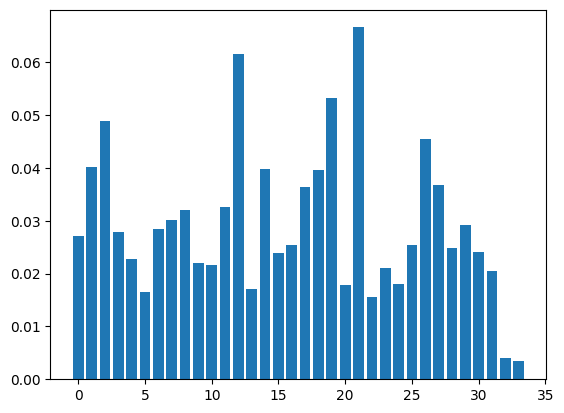

In [22]:
from xgboost import XGBClassifier
from matplotlib import pyplot
from xgboost import plot_importance

# Define dataset as all features
total_features = np.concatenate((expression_features, metadata_features), axis=1)
X_train, X_test, y_train, y_test = train_test_split(total_features, meta_file.iloc[:,0], test_size=0.2, random_state=42)

# fit model
model = XGBClassifier()
model.fit(X_train, y_train)

# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

#### Using feature importances, perform search over various thresholds with XGBoost

In [23]:
from sklearn.feature_selection import SelectFromModel
        
# Define the list of thresholds
thresholds = np.arange(0, 0.055, 0.0005)
n = []
best_threshold = []
test_acc = []
for thresh in thresholds:

    model = XGBClassifier()
    model.fit(X_train, y_train)

    # Select features using the threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # Train the model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    
    # Evaluate the model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    best_threshold.append(thresh)
    n.append(select_X_train.shape[1])
    test_acc.append(accuracy)

print("------------------------------------------")
print('RESULTS:')
best_acc_ind = np.argmax(test_acc)
best_acc = np.max(test_acc)
best_threshold = best_threshold[best_acc_ind]
best_n = n[best_acc_ind]
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (best_threshold,best_n, best_acc*100.0))

Thresh=0.000, n=34, Accuracy: 59.76%
Thresh=0.001, n=34, Accuracy: 59.76%
Thresh=0.001, n=34, Accuracy: 59.76%
Thresh=0.002, n=34, Accuracy: 59.76%
Thresh=0.002, n=34, Accuracy: 59.76%
Thresh=0.003, n=34, Accuracy: 59.76%
Thresh=0.003, n=34, Accuracy: 59.76%
Thresh=0.004, n=33, Accuracy: 60.98%
Thresh=0.004, n=32, Accuracy: 60.98%
Thresh=0.005, n=32, Accuracy: 60.98%
Thresh=0.005, n=32, Accuracy: 60.98%
Thresh=0.005, n=32, Accuracy: 60.98%
Thresh=0.006, n=32, Accuracy: 60.98%
Thresh=0.007, n=32, Accuracy: 60.98%
Thresh=0.007, n=32, Accuracy: 60.98%
Thresh=0.007, n=32, Accuracy: 60.98%
Thresh=0.008, n=32, Accuracy: 60.98%
Thresh=0.009, n=32, Accuracy: 60.98%
Thresh=0.009, n=32, Accuracy: 60.98%
Thresh=0.009, n=32, Accuracy: 60.98%
Thresh=0.010, n=32, Accuracy: 60.98%
Thresh=0.011, n=32, Accuracy: 60.98%
Thresh=0.011, n=32, Accuracy: 60.98%
Thresh=0.011, n=32, Accuracy: 60.98%
Thresh=0.012, n=32, Accuracy: 60.98%
Thresh=0.013, n=32, Accuracy: 60.98%
Thresh=0.013, n=32, Accuracy: 60.98%
T

#### Do it with SVM

In [25]:
n = []
best_threshold = []
test_acc = []
ind = 1
thresholds = np.arange(0, 0.055, 0.001)

# SVM Classifier
model = svm.SVC()
param_grid = {'C': [0.1,0.5,1,2,5,10],
            'kernel': ['linear','rbf',]}
grid_search_results = []
            
for thresh in thresholds:

    model = XGBClassifier()
    model.fit(X_train, y_train)
    
    # Select features using the threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # Train the model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)


    # Fit the SVM classifier on the combined features and perform classification
    # Perform grid search cross-validation
    model = svm.SVC()
    print("------------------------------------------")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=1)
    grid_search.fit(select_X_train, y_train)

    # Save the grid search object
    # grid_search_results.append(grid_search)

    print("Iteration ", ind)
    best_score = grid_search.best_score_
    print("Best Score:", best_score)
    grid_search_results.append(grid_search)
    ind += 1

    # Evaluate the model
    select_X_test = selection.transform(X_test)
    # Perform prediction using the best parameters
    y_pred = grid_search.predict(select_X_test) 
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    best_threshold.append(thresh)
    n.append(select_X_train.shape[1])
    test_acc.append(accuracy)

print("------------------------------------------")
print('RESULTS:')
best_acc_ind = np.argmax(test_acc)
best_acc = np.max(test_acc)
best_threshold = best_threshold[best_acc_ind]
best_n = n[best_acc_ind]
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (best_threshold,best_n, best_acc*100.0))

------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Iteration  1
Best Score: 0.6855774237217537
Thresh=0.000, n=34, Accuracy: 56.10%
------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Iteration  2
Best Score: 0.6855774237217537
Thresh=0.001, n=34, Accuracy: 56.10%
------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Iteration  3
Best Score: 0.6855774237217537
Thresh=0.002, n=34, Accuracy: 56.10%
------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Iteration  4
Best Score: 0.6855774237217537
Thresh=0.003, n=34, Accuracy: 56.10%
------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Iteration  5
Best Score: 0.6855774237217537
Thresh=0.004, n=32, Accuracy: 56.10%
------------------------------------------
Fitting 5 folds for each of 12 c

In [27]:
select_X_train.shape

(324, 2)